# Import libraries

In [69]:
import torch
import torch.nn as nn
from torchvision import models, transforms

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Load classes of the ImageNet datasets
to get the class of input image

In [70]:
!wget -O imagnet_classes.txt https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt

--2024-11-01 06:24:52--  https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [text/plain]
Saving to: ‘imagnet_classes.txt’

imagnet_classes.txt 100%[===================>]  29.85K  --.-KB/s    in 0.01s   

2024-11-01 06:24:52 (2.26 MB/s) - ‘imagnet_classes.txt’ saved [30564/30564]



In [71]:
classes = open('imagnet_classes.txt').read().strip().split('\n')

# Preprocessing

In [72]:
# Preprocess image
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:3, :, :]), # Select only the first 3 channels (RGB)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the image
img_path = '/content/puppy.png'  # Replace with your image path
img = Image.open(img_path)
input_img = preprocess(img)   # Add batch dimension

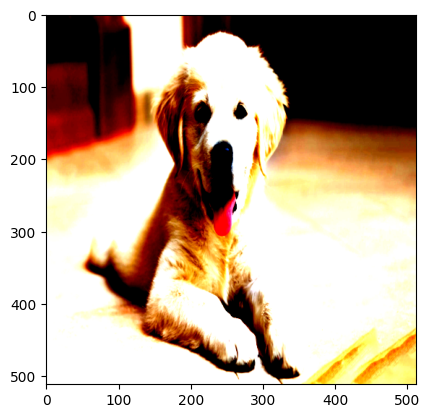

In [73]:
# C,W,H => W,H,C
plt.imshow(input_img.permute(1,2,0))

# Class Model to Grad-CAM

In [74]:
class ConvModel(nn.Module):
    def __init__(self,model):
        super(ConvModel, self).__init__()

        # Get the pretrained VGG19 network
        self.model = model

        self.features_conv = self.model.features

        # Max pool layer
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        # Average pool layer
        self.avg_pool = self.model.avgpool

        # Classifier layer
        self.classifier = self.model.classifier

        # Holders for gradients and activations from the last 5 layers
        self.gradients = None
        self.layer_activations = []

    # Hook to capture gradients
    def activations_hook(self, grad):
        self.gradients = grad

    # Hook for saving activations from the last 5 layers
    def save_activations(self, module, input, output):
        self.layer_activations.append(output)

    def forward(self, x):
        self.layer_activations = []  # Reset activations

        for p in self.model.features:
          if isinstance(p, nn.modules.conv.Conv2d):
              p.register_forward_hook(self.save_activations)

        x = self.features_conv(x)

        # Register a backward hook for gradients
        h = x.register_hook(self.activations_hook)

        x = self.max_pool(x)
        x = self.avg_pool(x)
        x = x.view((1, -1))  # Flatten for the classifier
        x = self.classifier(x)

        return x

    # Method to retrieve the gradients
    def get_activations_gradient(self):
        return self.gradients

    # Method to retrieve the activations
    def get_activations(self):
        return self.layer_activations

## use VGG-19 Model

In [75]:
pretrained_model = models.vgg19(pretrained=True)
pretrained_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [76]:
model = ConvModel(pretrained_model)

## Processing

In [77]:
# Forward pass
output = model(input_img)

# Get activations
activations = model.get_activations()

# Backward pass for the specific class (use the top predicted class)
class_idx = torch.argmax(output)  # Class with the highest score
model.zero_grad()
output[0, class_idx].backward()  # Backpropagate for the specific class

gradients = model.get_activations_gradient()

In [91]:
def generate_heatmap(activation, gradients):

    # Global average pooling of gradients over width and height dimensions
    weights = torch.mean(gradients, dim=[1, 2]) # 512,32,32 => 512
    weights = weights.squeeze()

    activation = activation.squeeze()

    # multiply activation with weights
    for i in range(activation.shape[0]):
      activation[i, :, :] *= weights[i]

    # take the mean
    heatmap = torch.mean(activation, dim=0)

    # Apply ReLU to discard negative values
    heatmap = torch.clamp(heatmap, min=0)

    # Normalize the heatmap
    heatmap /= torch.max(heatmap)

    return heatmap.detach().cpu().numpy()

In [85]:
heatmaps = []
for i, activation in enumerate(activations):
    heatmap = generate_heatmap(activation, gradients)
    heatmaps.append(heatmap)

## Animate Grad-CAM
for all conv-layers

In [86]:
def animate_heatmaps(i):
    ax.clear()
    heatmap = heatmaps[i]

    input_img = cv2.imread('puppy.png')
    heatmap = cv2.resize(heatmap, (input_img.shape[1], input_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Display the superimposed image
    ax.imshow(heatmap.astype(np.uint8))
    ax.set_title(f'Layer {i}')  # Adjust the layer number
    ax.axis('off')

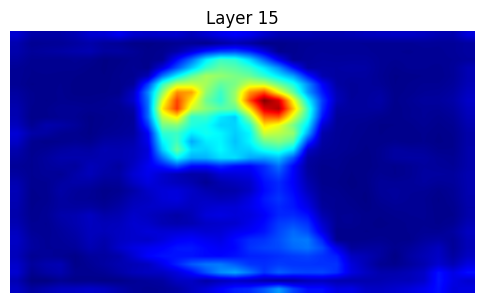

In [87]:
fig, ax = plt.subplots(figsize=(6, 6))

# Create the animation
anim = FuncAnimation(fig, animate_heatmaps, frames=len(heatmaps), interval=1000)

# Save or display the animation
anim.save('conv_layer_activation.gif', writer='imagemagick')

plt.show()

## Grad-CAM
for the last conv-layer

In [88]:
heatmap = heatmaps[-1]

input_img = cv2.imread('puppy.png')
heatmap = cv2.resize(heatmap, (input_img.shape[1], input_img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.5 + input_img
cv2.imwrite('heatmap.jpg', superimposed_img)

True

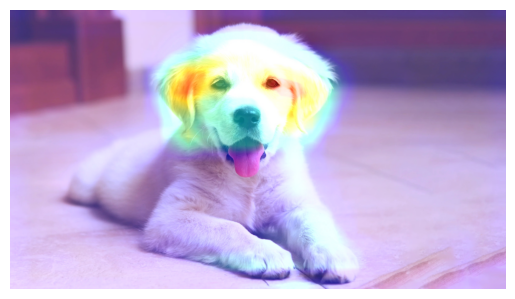

In [89]:
input_img = cv2.imread('heatmap.jpg')
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
plt.imshow(input_img)
plt.axis('off')
plt.show()

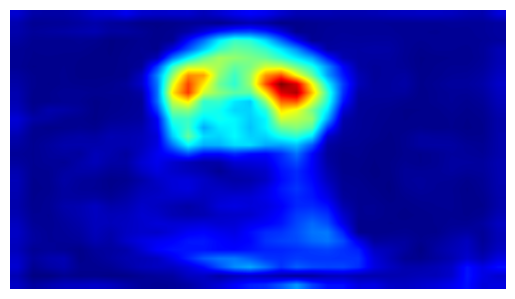

In [90]:
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
plt.imshow(heatmap)
plt.axis('off')
plt.show()